In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
import copy
import statistics
import seaborn as sns; sns.set()
from time import process_time
import math
import scipy as sp
import matplotlib
import gurobipy
from scipy.io import savemat

# Single-Agent Q-Learning in an MDP

In [1170]:
np.random.seed(2045)

A = 5  # num actions
S = 6  # num states

discount = 0.8

R = np.zeros((S,A))

for s in range(S):
    R[s,:] = (np.random.rand(A)-0.5) * np.exp((s+1)^2)
    #R[s,:] = (np.random.rand(A,A)+1) * ((s+1))
    #R1[s,:,:] = (np.random.rand(A,A)-0.55)    so that we have mixed (neg and pos values) for players
    max_R = np.max(abs(R[s,:]))
    R[s,:] /= max_R

state_trans = np.zeros((S,A,S))
for a in range(A):
    for s in range(S):
        state_trans[s,a,:] = np.random.rand(S) + 0.1
        state_trans[s,a,:] /= np.sum(state_trans[s,a,:])

def get_next_state(s, action, state_trans):
    probs = state_trans[s,action,:]
    return np.random.choice(S,p=probs)

In [1172]:
Q = np.zeros((S,A))
old_Q = np.zeros((S,A))

converged = 1e-8

Delta = 0
num_ep = int(1e3)
max_it_ep = 100

Q_iters = np.zeros((num_ep, S, A))


avg_rewards_1 = []
lr = 0.1
min_lr = 0.00001
lr_decay = 0.99
discount = 0.8

eps = 1.0
min_eps = 0.00001
eps_decay = 0.99


for ep in range(num_ep):
    s = np.random.choice(S)
    Q_old = copy.deepcopy(Q)
    Delta = 0
    tot_r = 0
    for it in range(max_it_ep):
        pr = np.random.rand()
        if pr > eps:
            a = np.argmax(Q[s,:])
        else:
            a = np.random.choice(A)
        r = R[s,a]
        next_s = get_next_state(s, a, state_trans)
        Q[s, a] = Q[s, a] + lr*(r + discount*max(Q[next_s,:]) - Q[s,a])
        s = copy.deepcopy(next_s)
        tot_r += r
    avg_rewards_1.append(tot_r/max_it_ep)
    Q_iters[ep] = Q.copy()
    if eps*eps_decay >= min_eps:
        eps *= eps_decay
    # if lr*lr_decay >= min_lr:
    #     lr *= lr_decay

In [1113]:
def smooth(scalars, weight):
    last = scalars[0]  
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  
        smoothed.append(smoothed_val)                       
        last = smoothed_val                                 
        
    return smoothed

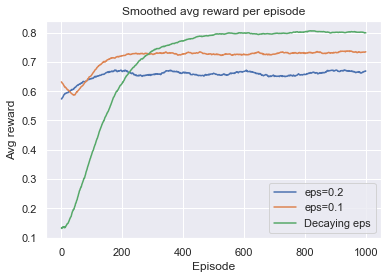

In [1142]:
plt.plot(smooth(avg_rewards_3,0.98),label="eps=0.2")
plt.plot(smooth(avg_rewards_2,0.98),label="eps=0.1")
plt.plot(smooth(avg_rewards_1,0.98),label="Decaying eps")

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Avg reward")
plt.title("Smoothed avg reward per episode")
#plt.plot(smooth(avg_rewards2,0.9))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


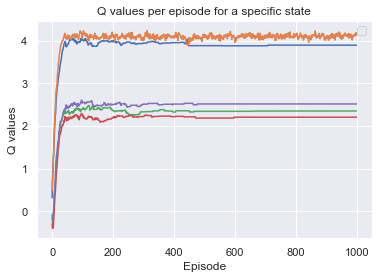

In [1174]:
plt.plot(Q_iters[:,0,:])

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Q values")
plt.title("Q values per episode for a specific state")
#plt.plot(smooth(avg_rewards2,0.9))
plt.show()

## Team Q-Learning

In [1346]:

# Define the states and some necessary info
N = 4  # num agents
A = 5  # num actions
S = 6  # num states
discount = 0.8

R = np.zeros((S,A,A,A,A))


np.random.seed(2045)



for s in range(S):
    R[s,:,:,:] = (np.random.rand(A,A,A,A)-0.5) * ((s+1))
    max_R = np.max(abs(R[s,:,:,:,:]))
    R[s,:,:,:] /= max_R


state_trans_det = np.zeros((S,A,A,A,A),dtype=int)
for s in range(S):
    for a1 in range(A):
        for a2 in range(A):
            for a3 in range(A):
                for a4 in range(A):
                    state_trans_det[s,a1,a2,a3,a4] = int(np.random.choice(S))


In [1351]:
det_pols = np.zeros((N,S),dtype=int)
Q_old = np.zeros((N,S,A))
Q_g = np.zeros((S,A,A,A,A))
v = np.zeros((N,S))
np.random.seed(2045)

discount = 0.8
eps = 1.0
min_eps = 0.000001
eps_decay = 0.99
iters = int(100)

episodes = 1000

Q_iters = np.zeros((episodes,S,A,A,A,A))

_avg_rews1= []
lr = 0.1
min_lr = 0.00001
lr_decay = 0.999


s = np.random.choice(S)
for ep in range(episodes):
    tot_rew = 0
    s = np.random.choice(S)

    for it in range(iters):
        pr = np.random.rand()
        if pr > eps:
            actions = det_pols[:,s]
        else:
            actions = np.random.randint(0,A,size=(N),dtype=int)
        r = R[s,actions[0],actions[1],actions[2],actions[3]]
        next_s = state_trans_det[s,actions[0],actions[1],actions[2],actions[3]]
        # print(np.argmax(Q_g[s,:,:,:], axis=None), Q_g[s,:,:,:].shape)
        # print(Q_g[s,ind_max[0], ind_max[1], ind_max[2]], np.max(Q_g[s,:,:,:]))
        Q_g[s, actions[0],actions[1],actions[2],actions[3]] = Q_g[s, actions[0],actions[1],actions[2],actions[3]] +\
              lr*(r + discount*np.max(Q_g[next_s,:,:,:,:]) - Q_g[s, actions[0],actions[1],actions[2],actions[3]])
        ind_max = np.unravel_index(np.argmax(Q_g[s,:,:,:,:], axis=None), Q_g[s,:,:,:,:].shape)
        det_pols[0,s] = ind_max[0]
        det_pols[1,s] = ind_max[1]
        det_pols[2,s] = ind_max[2]
        det_pols[3,s] = ind_max[3]
        v[:,s] = Q_g[s,ind_max[0], ind_max[1], ind_max[2], ind_max[3]]
        tot_rew += r
        #print(det_pols[:,s],ind_max)

        # if lr*lr_decay >= min_lr:
        #     lr *= lr_decay
        s = copy.deepcopy(next_s)
    if eps*eps_decay >= min_eps:
        eps *= eps_decay
    _avg_rews1.append(tot_rew/iters)
    Q_iters[ep] = Q_g



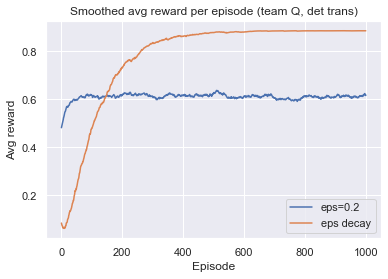

In [1354]:
plt.plot(smooth(_avg_rews3,0.95), label="eps=0.2")
plt.plot(smooth(_avg_rews1,0.95), label="eps decay")

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Avg reward")
plt.title("Smoothed avg reward per episode (team Q, det trans)")
#plt.plot(smooth(avg_rewards2,0.9))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


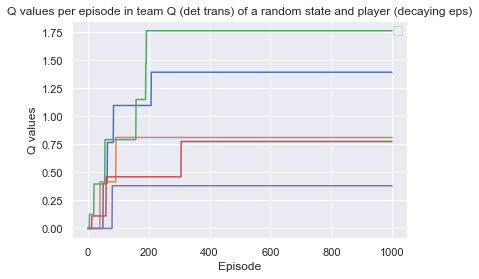

In [1167]:
s = 2
plt.plot(Q_iters[:,s,0,0,:,0])




plt.legend()
plt.xlabel("Episode")
plt.ylabel("Q values")
plt.title("Q values per episode in team Q (det trans) of a random state and player (decaying eps)")
#plt.plot(smooth(avg_rewards2,0.9))
plt.show()

## Distributed Q-Learning

In [1211]:
Q = np.zeros((N,S,A))
Qg_d = np.zeros((S,A,A,A,A))

det_pols = np.zeros((N,S),dtype=int)
det_pols_g = np.zeros((N,S),dtype=int)

discount = 0.8
np.random.rand(2044)

eps = 1.0
eps_decay = 0.99
min_eps = 0.00001
iters = 100
episodes = 1000

Q_itersd = np.zeros((episodes,N,S,A))
Qg_itersd = np.zeros((episodes,S,A,A,A,A))


av_rews1 = []

for ep in range(episodes):
    s = np.random.choice(S)
    tot_r = 0
    for it in range(iters):
        Q_old = copy.deepcopy(Q)
        pr = np.random.rand()
        if pr > eps:
            actions = det_pols[:,s]
        else:
            actions = np.random.randint(0,A,size=(N),dtype=int)
        r = R[s,actions[0],actions[1],actions[2],actions[3]]
        next_s = state_trans_det[s,actions[0],actions[1],actions[2],actions[3]]
        #print(det_pols)
        for n in range(N):
            Q[n,s,actions[n]] = max(Q[n,s,actions[n]], r+discount*max(Q[n,next_s,:]))
            if Q[n,s,actions[n]] > max(Q_old[n,s,:]):
                det_pols[n,s] = actions[n]
        # Qg_d[s, actions[0],actions[1],actions[2],actions[3]] = Qg_d[s, actions[0],actions[1],actions[2],actions[3]] +\
        #       lr*(r + discount*np.max(Qg_d[next_s,:,:,:,:]) - Qg_d[s, actions[0],actions[1],actions[2],actions[3]])
        s = copy.deepcopy(next_s)
        tot_r += r
    if eps*eps_decay >= min_eps:
        eps *= eps_decay
    av_rews1.append(tot_r/iters)
    Q_itersd[ep] = Q
    # Qg_itersd[ep] = Qg_d





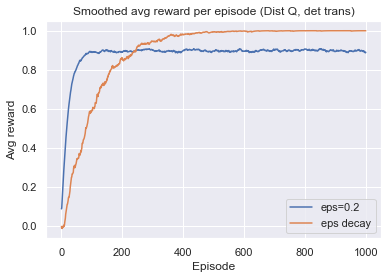

In [1212]:
# plt.plot(smooth(_avg_rews4,0.95), label="eps=0.05")
#plt.plot(smooth(_avg_rews3,0.95), label="eps=0.1")
plt.plot(smooth(av_rews2,0.95), label="eps=0.2")
plt.plot(smooth(av_rews1,0.9), label="eps decay")

plt.legend()
plt.xlabel("Episode")
plt.ylabel("Avg reward")
plt.title("Smoothed avg reward per episode (Dist Q, det trans)")
#plt.plot(smooth(avg_rewards2,0.9))
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


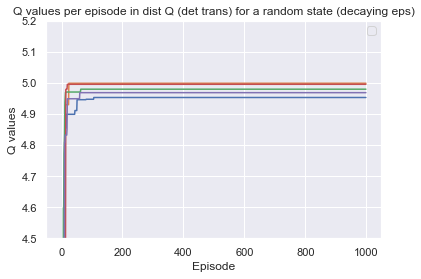

In [1216]:
s = 2
n = 1
plt.plot(Q_itersd[:,n,s,:])


plt.ylim(4.5, 5.2)


plt.legend()
plt.xlabel("Episode")
plt.ylabel("Q values")
plt.title("Q values per episode in dist Q (det trans) for a random state (decaying eps)")
#plt.plot(smooth(avg_rewards2,0.9))
plt.show()

## QD-Learning

In [1315]:
N = 10
adj_mat = np.ones((N,N))
for i in range(N):
    for j in range(i,N):
        p = np.random.rand()
        if p > 0.5:
            adj_mat[i,j] = 0
            adj_mat[j,i] = 0
# adj_mat

In [1338]:

np.random.seed(2045)

A = 2  # num actions
S = 2  # num states

discount = 0.7

r_means = np.random.uniform(0, 100, size=(N,S,A))
var = np.sqrt(100)

state_trans = np.zeros((N,S,A,S))
for n in range(N):
    for a in range(A):
        for s in range(S):
            state_trans[n, s,a,:] = np.random.rand(S) + 0.01
            state_trans[n, s,a,:] /= np.sum(state_trans[n,s,a,:])

def get_next_state(s, actions, state_trans):
    prob1 = 1
    prob2 = 1
    for n in range(N):
        prob1 *= state_trans[n, s, actions[n], 0]
        prob2 *= state_trans[n, s, actions[n], 1]
    probs = np.array([prob1[0], prob2[0]])
    probs /= np.sum(probs)
    return np.random.choice(S,p=probs)


In [1342]:
det_pols = np.zeros((N,S),dtype=int)
iters = int(1e3)


np.random.seed(2045)
Q_iters = np.zeros((iters, N, S, A))


Q = np.random.rand(N,S,A)*10


a = 0.01
b = 0.01
tau1 = 1.1
tau2 = 0.2
def alpha(k, a, tau1=1.0):
    return a/pow((k+1),tau1)

def beta(k, b, tau2=0.2):
    return b/pow((k+1),tau2)

visits = np.zeros((N,A))

rn = np.zeros((N,1))


s = np.random.choice(S)

for it in range(iters):
    actions = np.random.randint(0, A, size = (N,1))
    next_s = get_next_state(s, actions, state_trans)
    Q_iters[it,...] = copy.deepcopy(Q)


    
    for n in range(N):
        rn[n] = np.random.normal(loc=r_means[n,s,actions[n]],scale=np.sqrt(var))
    ravg = np.mean(rn)
    for n in range(N):
        q_dif_g = 0
        for neig in range(N):
            q_dif_g += adj_mat[n,neig]*(Q[n,s,actions[n]] - Q[neig,s,actions[n]])
        
        al = alpha(visits[n,actions[n]], a, tau1)
        be = beta(visits[n,actions[n]], b, tau2)
        visits[n,actions[n]] += 1
        Q[n, s, actions[n]] = Q[n, s, actions[n]] - be*q_dif_g +\
             al*(rn[n]+discount*np.min(Q[n,next_s,:])-Q[n,s,actions[n]])
       
    s = copy.deepcopy(next_s)




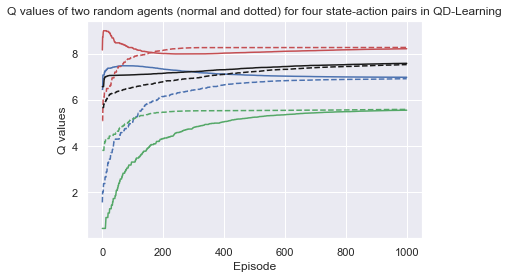

In [1345]:
n = 3
plt.plot(Q_iters[:,n,0,0], 'r')
plt.plot(Q_iters[:,n,0,1], 'b')
plt.plot(Q_iters[:,n,1,0], 'g')
plt.plot(Q_iters[:,n,1,1], 'k')

n = 4
plt.plot(Q_iters[:,n,0,0], 'r--')
plt.plot(Q_iters[:,n,0,1], 'b--')
plt.plot(Q_iters[:,n,1,0], 'g--')
plt.plot(Q_iters[:,n,1,1], 'k--')



plt.xlabel("Episode")
plt.ylabel("Q values")
plt.title("Q values of two random agents (normal and dotted) for four state-action pairs in QD-Learning")
plt.show()

## Fully-Decentralized Multi-Agent Reinforcement Learning with Networked Agents

### Distributed  

In [1233]:
N = 10
A = 2  # num actions
S = 10  # num states
np.random.seed(2045)
adj_mat = np.zeros((N,N))
for i in range(N):
    for j in range(i,N):
        p = np.random.rand()
        if p < 4/N:
            adj_mat[i,j] = np.random.rand()
        if p < 4/N:
            adj_mat[j,i] = np.random.rand()


rsum = None
csum = None
while (np.any(rsum != 1)) | (np.any(csum != 1)):
    adj_mat /= adj_mat.sum(0)
    adj_mat = adj_mat / adj_mat.sum(1)[:, np.newaxis]
    rsum = adj_mat.sum(1)
    csum = adj_mat.sum(0)

rsum = adj_mat.sum(1)
csum = adj_mat.sum(0)





r_means = np.random.uniform(0, 4, size=(N,S,int(pow(A,N))))



state_trans = np.zeros((S,int(pow(A,N)),S))
for s in range(S):
    for a in range(int(pow(A,N))):
        state_trans[s,a,:] = np.random.rand(S) + 1e-5
        state_trans[s,a,:] /= np.sum(state_trans[s,a,:])


def get_next_state(s, action, state_trans):
    probs = state_trans[s,action,:]
    return np.random.choice(S,p=probs)


In [1234]:


def lr_theta(t,tau=0.85):
    return 1/((t+1)**tau)

def lr_omega(t,tau=0.65):
    return 1/((t+1)**tau)

def pi(q, theta, A=2):
    pi = np.zeros((A,1))
    sum_exp = 0
    for i in range(A):
        sum_exp += np.exp((q[i].T)@theta)
    for i in range(A):
        pi[i]=np.exp((q[i].T)@theta)/sum_exp
    return pi

In [1235]:
at = np.random.randint(0,A, size=(N,1))
at_next = np.random.randint(0,A, size=(N,1))
r = np.zeros((N,1))
s = np.random.randint(0,S)
s_next = np.random.randint(0,S)
q_theta = np.random.rand(N,S,A,5,1)
theta = np.random.rand(N,5,1)
delta = np.zeros((N,1))
psi = np.zeros((N,1))
iters = 500
policies = np.zeros((N,S,A,1))
J = np.zeros((iters,1))
mu = np.zeros((N,1))

omega = np.random.rand(N,10,1)
omega_bar = np.random.rand(N,10,1)
phi = np.random.rand(N,S*int(A**N),10,1)


In [1236]:
for it in range(iters):
    joint_action = 0
    for i in range(N):
        joint_action += int(int(2**i)*at[i])
    s_next = get_next_state(s, joint_action, state_trans)
    J_tmp = 0
    for i in range(N):
        r[i] = np.random.uniform(r_means[i,s,joint_action]-0.5,r_means[i,s,joint_action]+0.5)
        mu[i] = (1-lr_omega(it))*mu[i] + lr_omega(it)*r[i]
        policies[i,s_next] = pi(q_theta[i,s_next],theta[i])
        at_next[i] = np.random.choice(A,p=policies[i,s_next].reshape(A))
        J_tmp += r[i]
    joint_action_next = 0
    for i in range(N):
        joint_action_next += int(int(2**i)*at_next[i])
    if it == 0:
        J[it] = J_tmp/N
    if it != 0 and it != iters-1:
        J[it+1] = (J[it]*it + J_tmp/N)/(it+1)
    #J[it] = J_tmp/N
    for i in range(N):
        Qt = (omega[i].T)@phi[i,joint_action]
        Qt_next = (omega[i].T)@phi[i,joint_action_next]
        delta[i] = r[i] - mu[i] + Qt_next - Qt
        grad = phi[i,joint_action]
        omega_bar[i] = omega[i] + lr_omega(it)*delta[i]*grad
        Adv = Qt
        grad_pi  = q_theta[i,s,at[i]]
        for act in range(A):
            joint_act_tmp = joint_action
            joint_act_tmp -= int(int(2**i)*at[i])
            joint_act_tmp += int(int(2**i)*act)
            Qt_tmp = (omega[i].T)@phi[i,joint_act_tmp]
            Adv -= Qt_tmp*policies[i,s,act]
            grad_pi -= policies[i,s,act]*q_theta[i,s,act]
        theta[i] = theta[i] + lr_theta(it)*grad_pi*Adv
    for i in range(N):
        omega_tmp = 0
        for j in range(N):
            omega_tmp += adj_mat[i,j]*omega_bar[j]
        omega[i] = omega_tmp
    s = copy.deepcopy(s_next)
    at = copy.deepcopy(at_next)

### Centralized

In [1237]:
at = np.random.randint(0,A, size=(N,1))
at_next = np.random.randint(0,A, size=(N,1))
r = np.zeros((N,1))
s = np.random.randint(0,S)
s_next = np.random.randint(0,S)
q_theta = np.random.rand(S,int(A**N),5,1)
theta = np.random.rand(5,1)
delta = 0
psi = 0
policy = np.zeros((S,int(A**N),1))
J_cent = np.zeros((iters,1))
mu = 1

omega = np.random.rand(10,1)
omega_bar = np.random.rand(10,1)
phi = np.random.rand(S*int(A**N),10,1)


In [1238]:
def get_actions(joint_action_next):
    actions = [0]*N
    n = joint_action_next
    counter = 0
    while (n>0):
        a = int(float(n%2))
        actions[counter] = a
        n = (n-a)/2
        counter += 1
    return actions

In [1239]:
for it in range(iters):
    joint_action = 0

    for i in range(N):
        joint_action += int(int(2**i)*at[i])
    s_next = get_next_state(s, joint_action, state_trans)
    J_tmp = 0
    
    for i in range(N):
        r[i] = np.random.uniform(r_means[i,s,joint_action]-0.5,r_means[i,s,joint_action]+0.5)
        J_tmp += r[i]

    r_mean = J_tmp/N
    mu = (1-lr_omega(it))*mu + lr_omega(it)*r_mean

    policy[s_next] = pi(q_theta[s_next],theta,A=int(A**N))
    #print(policy[s_next])
    joint_action_next = np.random.choice(int(A**N),p=policy[s_next].reshape(int(A**N)))

    at_next = get_actions(joint_action_next)

    if it == 0:
        J_cent[it] = J_tmp/N
    if it != 0 and it != iters-1:
        J_cent[it+1] = (J[it]*it + J_tmp/N)/(it+1)
    #J[it] = J_tmp/N
    Qt = (omega.T)@phi[joint_action]
    Qt_next = (omega.T)@phi[joint_action_next]
    delta = r_mean - mu + Qt_next - Qt
    grad = phi[joint_action]
    omega_bar = omega + lr_omega(it)*delta*grad
    Adv = Qt
    grad_pi  = q_theta[s,at[i]]
    for act in range(int(A**N)):
        Qt_tmp = (omega.T)@phi[act]
        Adv -= Qt_tmp*policy[s,act]
        grad_pi -= policy[s,act]*q_theta[s,act]
    theta = theta + lr_theta(it)*grad_pi*Adv

    s = copy.deepcopy(s_next)
    at = copy.deepcopy(at_next)

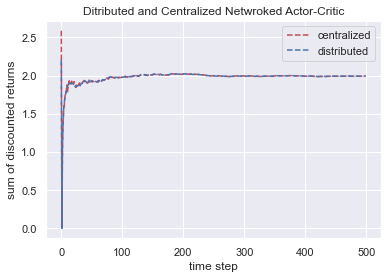

In [1240]:
plt.plot(J_cent, 'r--', label='centralized')
plt.plot(J,'b--', label='distributed')
plt.legend()
plt.xlabel('time step')
plt.ylabel('sum of discounted returns')
plt.title("Ditributed and Centralized Netwroked Actor-Critic")
plt.show()